In [2]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
import os
import torch
from concurrent.futures import ProcessPoolExecutor

beam1 dt is: 1e-07
beam1 beta is: 0.10471975511965977
beam1 omega is: 6283.185307179586
beam1 tao is: 0.003
beam1 c is: 299792458.0147872
beam1 t is: [0.0000e+00 1.0000e-07 2.0000e-07 ... 2.9997e-03 2.9998e-03 2.9999e-03]
beam1 len is: 30000
beam1 E0 is: 9.359987503732171e-13
beam1 step_max is: 3333


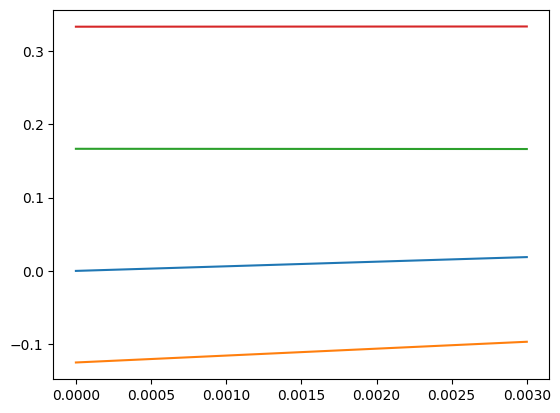

In [6]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

class BEAM:
    def __init__(self,f = 0.0,beta = 2*np.pi/60):
        self.wavelength = 1064e-9                               #波长 单位m
        self.data_num = int(1e8)                                #数据长度
        self.time = 10.0                                        #时长
        self.mu_0 = 12.566370614e-7                             #真空磁导率 单位N*A^(-2)
        self.epsilon_0 = 8.854187817e-12                        #真空介电常数 单位F*m^(-1)
        self.n = 1.45                                           #光纤折射率
        self.c = 1/sqrt(self.mu_0*self.epsilon_0)               #光速
        self.data_num = int(1e8)                                #数据总长度
        self.dt = self.time / self.data_num                     #时间间隔
        self.tao = 3 / 1e3                                      #积分时间
        self.step_max = int(self.time / self.tao)               #循环次数
        self.beta = beta                                        #扰动信号幅度
        self.omega = 2*np.pi*f                                  #扰动信号频率
        self.P = 100                                            #光功率
        self.len = int(self.tao / self.dt)                      #tao时间内的数据长度
        self.t = np.linspace(0,self.tao - self.dt,self.len)     #时间序列tao
        self.E0 = self.cal_E0()                                 #电场强度

    def beam_phase0(self,t = np.array([])):
        ref_w = 2*np.pi*1
        phase = 2*np.pi*np.sin(ref_w*t)
        return phase
    
    def beam_phase1(self,t = np.array([])):
        ref_w = 2*np.pi*1
        phase = 2*np.pi*np.sin(ref_w*t) + 2*np.pi*np.sin(ref_w*t/2) - np.pi / 4  
        return phase
    
    def beam_phase2(self,t = np.array([])):
        phase = -2*np.pi*t/self.time + np.pi/3
        return phase
    
    def beam_phase3(self,t = np.array([])):
        phase = 2*np.pi*t/self.time + 2*np.pi/3
        return phase
    
    def cal_E0(self):
        omega = self.c / self.wavelength / self.n
        E0 = 1/omega*sqrt(4*self.P/np.pi/self.n*sqrt(self.mu_0/self.epsilon_0))
        return E0

beam0 = BEAM()
beam1 = BEAM(1e3)
beam2 = BEAM(2e3)
beam3 = BEAM(3e3)
t = beam0.t
phase0 = beam0.beam_phase0(t)
phase1 = beam0.beam_phase1(t)
phase2 = beam0.beam_phase2(t)
phase3 = beam0.beam_phase3(t)
plt.plot(t,phase0 / np.pi / 2)
plt.plot(t,phase1 / np.pi / 2)
plt.plot(t,phase2 / np.pi / 2)
plt.plot(t,phase3 / np.pi / 2)

print('beam1 dt is:',beam1.dt)
print('beam1 beta is:',beam1.beta)
print('beam1 omega is:',beam1.omega)
print('beam1 tao is:',beam1.tao)
print('beam1 c is:',beam1.c)
print('beam1 t is:',beam1.t)
print('beam1 len is:',beam1.len)
print('beam1 E0 is:',beam1.E0)
print('beam1 step_max is:',beam1.step_max)


locset simulation start
time is: 0.0
time is: 0.003
time is: 0.006
time is: 0.009000000000000001
time is: 0.012
time is: 0.015
time is: 0.018000000000000002
time is: 0.021
time is: 0.024
time is: 0.027
time is: 0.03
time is: 0.033
time is: 0.036000000000000004
time is: 0.039
time is: 0.042
time is: 0.045
time is: 0.048
time is: 0.051000000000000004
time is: 0.054
time is: 0.057
time is: 0.06
time is: 0.063
time is: 0.066
time is: 0.069
time is: 0.07200000000000001
time is: 0.075
time is: 0.078
time is: 0.081
time is: 0.084
time is: 0.08700000000000001
time is: 0.09
time is: 0.093
time is: 0.096
time is: 0.099
time is: 0.10200000000000001
time is: 0.105
time is: 0.108
time is: 0.111
time is: 0.114
time is: 0.117
time is: 0.12
time is: 0.123
time is: 0.126
time is: 0.129
time is: 0.132
time is: 0.135
time is: 0.138
time is: 0.14100000000000001
time is: 0.14400000000000002
time is: 0.147
time is: 0.15
time is: 0.153
time is: 0.156
time is: 0.159
time is: 0.162
time is: 0.165
time is: 0.16

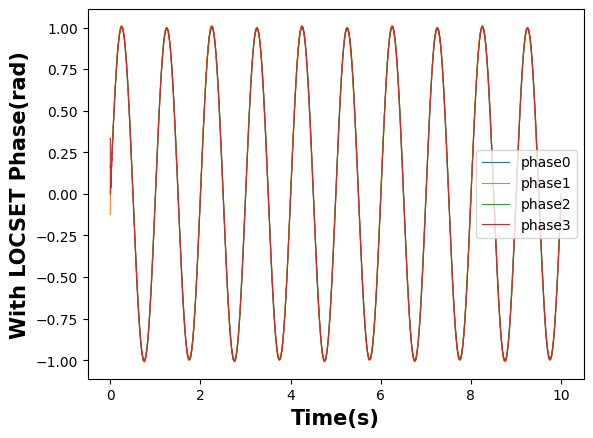

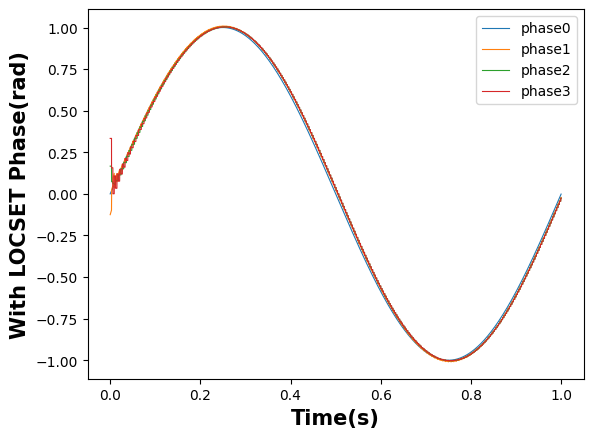

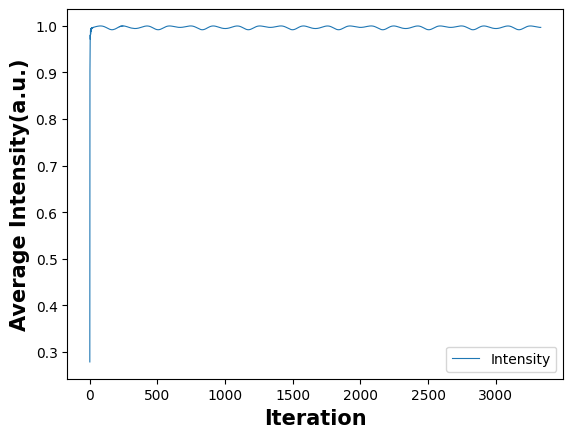

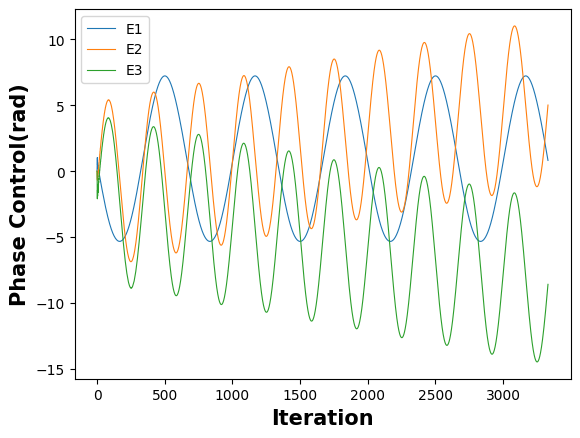

In [7]:
class LOCSET:
    def __init__(self):
        self.beam_num = 4
        self.P_pd = 0.88                                #单位A/W 光电探测器灵敏度 用于表征探测器输出光电流（电压）与入射光功率间的关系
        self.A = 1.1*1.1*1e-6                           #单位平方米 光电探测器的光敏面面积
        self.step_max,self.data_num,self.data_len,self.tao,self.dt,self.t,self.time,self.E0 = self.beam_para()
        self.delta = np.zeros((self.beam_num,self.step_max))
        self.s = np.zeros((self.beam_num,self.step_max))
        self.phase = np.zeros((self.beam_num,self.data_num))
        self.alpha = 3.8e33
    
    def beam_para(self):
        step_max = beam0.step_max
        data_num = beam0.data_num
        data_len = beam0.len
        tao = beam0.tao
        dt = beam0.dt
        t = beam0.t
        time = beam0.time
        E0 = beam0.E0
        return step_max,data_num,data_len,tao,dt,t,time,E0
    
    def locset_sim(self):
        
        print('locset simulation start')        
        w1 = torch.tensor(beam1.omega).to(device); w2 = torch.tensor(beam2.omega).to(device); w3 = torch.tensor(beam3.omega).to(device)
        t0 = torch.tensor(self.t).to(device); tao = torch.tensor(self.tao).to(device); dt = torch.tensor(self.dt).to(device)        
        sin1 = torch.sin(w1*t0); sin2 = torch.sin(w2*t0); sin3 = torch.sin(w3*t0)
        i_pdt = torch.zeros_like(t0).to(device)
        s_factor = 1/tao*dt
        i_pd_factor = beam0.epsilon_0/beam0.mu_0
        
        for i in range(int(self.step_max)):
            t = self.t + i*self.tao
            print('time is:',i*self.tao)
            self.delta[1:4,i] = self.delta[1:4,i-1] + self.alpha*self.s[1:4,i-1]            
            
            phase0 = torch.tensor(beam0.beam_phase0(t)).to(device)
            phase1 = torch.tensor(beam1.beam_phase1(t) + self.delta[1,i]).to(device)
            phase2 = torch.tensor(beam2.beam_phase2(t) + self.delta[2,i]).to(device)
            phase3 = torch.tensor(beam3.beam_phase3(t) + self.delta[3,i]).to(device)
            
            phases = torch.stack((phase0, phase1 + beam1.beta*sin1, phase2 + beam2.beta*sin2, phase3 + beam3.beta*sin3))
            E_re = self.E0*torch.cos(phases).to(device); E_im = self.E0*torch.sin(phases).to(device);
            E_t_re = torch.sum(E_re, dim=0); E_t_im = torch.sum(E_im, dim=0)         
            E_t = E_t_re**2 + E_t_im**2
            
            i_pdt = self.P_pd*self.A*1/2*torch.sqrt(torch.tensor(i_pd_factor))*E_t.to(device)
            self.delta[0,i] = torch.sum(i_pdt).to(device).cpu().numpy()
            
            phases = torch.stack((phase0, phase1, phase2, phase3)).cpu().numpy()
            self.phase[:,i*self.data_len:(i+1)*self.data_len] = phases
            
            results = s_factor * torch.stack([torch.sum(i_pdt * sin1),torch.sum(i_pdt * sin2),torch.sum(i_pdt * sin3)])
            self.s[1:4, i] = results.cpu().numpy()
            
    def plot(self):
        sample = 1000
        data_max = self.step_max*self.data_len
        t = np.linspace(0,self.time,int(data_max/sample))
        phase0 = self.phase[0,:data_max:sample]
        phase1 = self.phase[1,:data_max:sample]
        phase2 = self.phase[2,:data_max:sample]
        phase3 = self.phase[3,:data_max:sample]
        
        plt.figure()
        plt.plot(t,phase0 / np.pi / 2,label = 'phase0',linewidth=0.8)
        plt.plot(t,phase1 / np.pi / 2,label = 'phase1',linewidth=0.8)
        plt.plot(t,phase2 / np.pi / 2,label = 'phase2',linewidth=0.8)
        plt.plot(t,phase3 / np.pi / 2,label = 'phase3',linewidth=0.8)
        plt.xlabel('Time(s)',fontsize=15, fontweight='bold')
        plt.ylabel('With LOCSET Phase(rad)',fontsize=15, fontweight='bold')
        plt.legend()
        
        t = np.linspace(0,self.time/self.time,int(data_max/sample/self.time))
        phase0 = self.phase[0,:int(data_max/self.time):sample]
        phase1 = self.phase[1,:int(data_max/self.time):sample]
        phase2 = self.phase[2,:int(data_max/self.time):sample]
        phase3 = self.phase[3,:int(data_max/self.time):sample]
        plt.figure()
        plt.plot(t,phase0 / np.pi / 2,label = 'phase0',linewidth=0.8)
        plt.plot(t,phase1 / np.pi / 2,label = 'phase1',linewidth=0.8)
        plt.plot(t,phase2 / np.pi / 2,label = 'phase2',linewidth=0.8)
        plt.plot(t,phase3 / np.pi / 2,label = 'phase3',linewidth=0.8)
        plt.xlabel('Time(s)',fontsize=15, fontweight='bold')
        plt.ylabel('With LOCSET Phase(rad)',fontsize=15, fontweight='bold')
        plt.legend()
        
        intensity = self.delta[0,:] / np.max(self.delta[0,:])
        plt.figure()
        plt.plot(intensity,label = 'Intensity',linewidth=0.8)
        plt.xlabel('Iteration',fontsize=15, fontweight='bold')
        plt.ylabel('Average Intensity(a.u.)',fontsize=15, fontweight='bold')
        plt.legend()
        
        delta1 = self.delta[1,:]
        delta2 = self.delta[2,:]
        delta3 = self.delta[3,:]
        
        plt.figure()
        plt.plot(delta1,label = 'E1',linewidth=0.8)
        plt.plot(delta2,label = 'E2',linewidth=0.8)
        plt.plot(delta3,label = 'E3',linewidth=0.8)
        plt.xlabel('Iteration',fontsize=15, fontweight='bold')
        plt.ylabel('Phase Control(rad)',fontsize=15, fontweight='bold')
        plt.legend()        
            
locset = LOCSET()
locset.locset_sim()
locset.plot()